In [251]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.extend(['c:/PycharmProjects/finance/src/'])
sys.path.extend(['c:/PycharmProjects/finance/'])
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, Plotting
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, objective_functions
import quantstats as qs
from src.port_cross_val import *
from src.metrics import extend_pandas_custom
from configs import COMPANIES_LIST, start_date, end_date
from utils import smartDataReader,get_last_raw,deal_with_add_constraints,prepare_FX,get_mean
pd.set_option("display.max_columns", 101)
pypfopt.__version__
import yfinance as yf
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 100000})
qs.extend_pandas()
extend_pandas_custom()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
ASSETS=['RDS-A', 'BP',"TOT","CVX",'RUB=X',"XOM","MUR"]
ickers = ['RDS-A', 'BP',"TOT","CVX",'RUB=X',"XOM","MUR"]
# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = datetime.strptime('2018-02-01','%Y-%m-%d')
end_date = datetime.strptime('2020-01-1' ,'%Y-%m-%d')
# User pandas_reader.data.DataReader to load the desired data. As simple as that.
prices= data.DataReader(ickers, 'yahoo', start_date, end_date)['Adj Close']

In [253]:
# prices[['RUB=X']].values

In [254]:
from pandas.core.base import PandasObject as _po

def make_all_columns_in_rubs(df):
    price_df=df[['RUB=X']]
    rest_df=df.drop("RUB=X", axis=1)
    rest_df_in_rubs=rest_df*price_df.values
    res_df=pd.concat([rest_df_in_rubs,price_df],axis=1)
    return res_df
def make_rub_column_in_usd(df):
    rub_price_df=1/df[['RUB=X']]
    rest_df=df.drop("RUB=X", axis=1)
    res_df=pd.concat([rest_df,rub_price_df],axis=1)
    return res_df
def load_df(path="c:/PycharmProjects/finance/brent.csv"):
    df=pd.read_csv(path,sep=";")
    df.set_index("Date")
    df['Date']=df['Date'].apply(pd.to_datetime)
    df=df.set_index("Date")
    return df
_po.make_all_columns_in_rubs=make_all_columns_in_rubs
_po.make_rub_column_in_usd=make_rub_column_in_usd

In [255]:
brent=load_df("c:/PycharmProjects/finance/brent.csv")
gas=load_df("c:/PycharmProjects/finance/gas.csv")
reserves=load_df("c:/PycharmProjects/finance/reserves_CB.csv")

In [256]:
custom_df=pd.concat([brent,gas,reserves],axis=1)

In [257]:
prices=prices.dropna(axis=0)
prices=prices.make_rub_column_in_usd()
prices.head(5)

ext_prices=prices.join(custom_df,how="left")
ext_prices.head(3)

,RDS-A,BP,TOT,CVX,XOM,MUR,RUB=X,Brent,Gas,Reserves
Date,,,,,,,,,,
2018-02-01,60.556103,36.905304,52.277752,114.842606,80.461479,28.843805,0.017800,66.65,6.24,NaN
2018-02-02,58.664547,35.032806,50.565178,108.449760,76.360260,27.037626,0.017875,67.45,2.91,449.8
2018-02-05,56.258686,33.858227,47.828583,102.998932,72.015137,25.974094,0.017726,73.14,2.77,NaN


In [258]:
ext_prices=ext_prices.groupby(pd.Grouper(key = None, freq = 'w')).apply(get_last_raw)

# prices=prices.dropna()
# prices.tail(5)

In [259]:
# ext_prices

## Stocks,USD/RUB,RESERVES

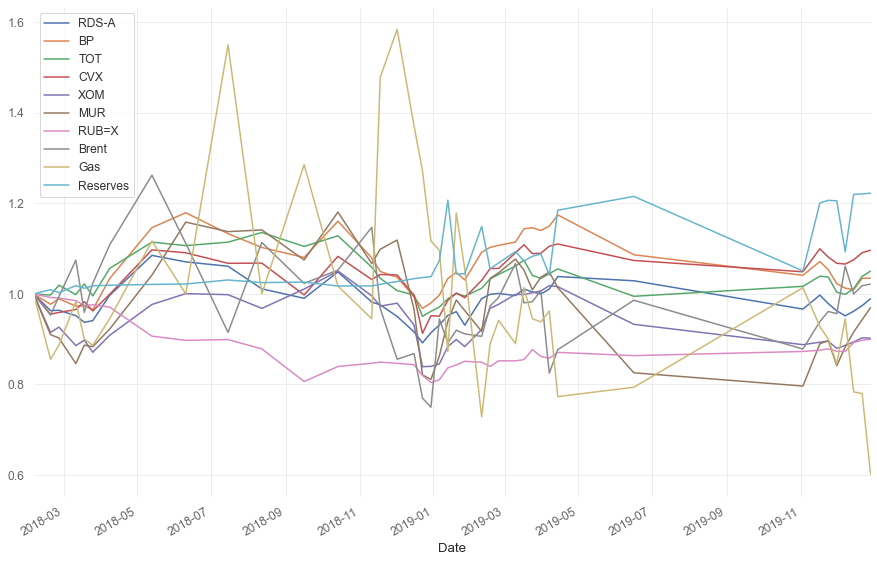

In [260]:
# prices_with_reserves=prices_with_reserves.loc['2019-07-01':"2020-05-01"]
ext_prices=ext_prices.dropna(axis=0)
(ext_prices/ext_prices.iloc[0]).plot(figsize=(15,10))

### Analysis based on correlation
#### We can see, that when brent prices are increasing, USD/RUB increases a little (-0.11).  But when brent price decreases - it immediately affect USB=RUB ( -0.24).  So influence of  increase in brent is lower that decline

In [261]:
ext_prices=ext_prices.dropna(axis=0)
ext_prices.pct_change().corr()

,RDS-A,BP,TOT,CVX,XOM,MUR,RUB=X,Brent,Gas,Reserves
RDS-A,1.000000,0.880293,0.604907,0.791290,0.676888,0.520339,0.010281,0.198460,-0.080636,0.332358
BP,0.880293,1.000000,0.741596,0.809939,0.766451,0.678633,-0.006450,0.150057,-0.167952,0.206109
TOT,0.604907,0.741596,1.000000,0.729065,0.641642,0.661285,0.037068,0.134945,-0.045225,0.015145
CVX,0.791290,0.809939,0.729065,1.000000,0.707536,0.736065,0.161907,0.216000,-0.088198,0.150879
XOM,0.676888,0.766451,0.641642,0.707536,1.000000,0.775377,-0.072858,0.056067,0.071312,0.084806
MUR,0.520339,0.678633,0.661285,0.736065,0.775377,1.000000,0.112051,0.103887,0.076815,-0.001813
RUB=X,0.010281,-0.006450,0.037068,0.161907,-0.072858,0.112051,1.000000,-0.024173,-0.224651,0.160055
Brent,0.198460,0.150057,0.134945,0.216000,0.056067,0.103887,-0.024173,1.000000,-0.301680,0.078854
Gas,-0.080636,-0.167952,-0.045225,-0.088198,0.071312,0.076815,-0.224651,-0.301680,1.000000,-0.489152
Reserves,0.332358,0.206109,0.015145,0.150879,0.084806,-0.001813,0.160055,0.078854,-0.489152,1.000000


In [262]:
pct_changes=ext_prices.pct_change()
pct_changes=pct_changes[pct_changes['Brent']>0]
pct_changes.corr()
# prices_with_reserves
# ALL IN RUBBLES

,RDS-A,BP,TOT,CVX,XOM,MUR,RUB=X,Brent,Gas,Reserves
RDS-A,1.000000,0.915712,0.699905,0.841896,0.739754,0.640208,-0.155824,-0.008271,0.232370,0.152364
BP,0.915712,1.000000,0.843351,0.899194,0.882303,0.776965,-0.155938,-0.012745,0.184146,0.054519
TOT,0.699905,0.843351,1.000000,0.771969,0.817552,0.749462,-0.289347,0.067773,0.104858,-0.013462
CVX,0.841896,0.899194,0.771969,1.000000,0.801432,0.786994,-0.233728,0.062680,0.160145,0.031429
XOM,0.739754,0.882303,0.817552,0.801432,1.000000,0.875277,-0.154602,-0.083468,0.328923,-0.196185
MUR,0.640208,0.776965,0.749462,0.786994,0.875277,1.000000,-0.144505,0.092562,0.232316,-0.145853
RUB=X,-0.155824,-0.155938,-0.289347,-0.233728,-0.154602,-0.144505,1.000000,-0.395713,-0.272648,0.095091
Brent,-0.008271,-0.012745,0.067773,0.062680,-0.083468,0.092562,-0.395713,1.000000,-0.060049,0.067628
Gas,0.232370,0.184146,0.104858,0.160145,0.328923,0.232316,-0.272648,-0.060049,1.000000,-0.552184
Reserves,0.152364,0.054519,-0.013462,0.031429,-0.196185,-0.145853,0.095091,0.067628,-0.552184,1.000000


In [263]:
pct_changes=ext_prices.pct_change()
pct_changes=pct_changes[pct_changes['Brent']<0]
pct_changes.corr()
# pct_changes

,RDS-A,BP,TOT,CVX,XOM,MUR,RUB=X,Brent,Gas,Reserves
RDS-A,1.000000,0.808259,0.376437,0.695242,0.600146,0.246171,0.172172,0.240984,-0.357651,0.659604
BP,0.808259,1.000000,0.451997,0.660348,0.619076,0.425527,0.190666,0.299820,-0.604667,0.535127
TOT,0.376437,0.451997,1.000000,0.658047,0.381134,0.442210,0.496019,0.055512,-0.195562,0.085807
CVX,0.695242,0.660348,0.658047,1.000000,0.595206,0.641990,0.561634,0.178835,-0.265957,0.340743
XOM,0.600146,0.619076,0.381134,0.595206,1.000000,0.649079,-0.015549,0.066271,-0.100095,0.426148
MUR,0.246171,0.425527,0.442210,0.641990,0.649079,1.000000,0.428756,-0.226425,-0.037181,0.253630
RUB=X,0.172172,0.190666,0.496019,0.561634,-0.015549,0.428756,1.000000,0.052743,-0.177427,0.246975
Brent,0.240984,0.299820,0.055512,0.178835,0.066271,-0.226425,0.052743,1.000000,-0.666109,0.388795
Gas,-0.357651,-0.604667,-0.195562,-0.265957,-0.100095,-0.037181,-0.177427,-0.666109,1.000000,-0.477844
Reserves,0.659604,0.535127,0.085807,0.340743,0.426148,0.253630,0.246975,0.388795,-0.477844,1.000000


c:\python_venvs\finance\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\python_venvs\finance\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\python_venvs\finance\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
c:\python_venvs\finance\lib\site-packages\pandas\plotting\_matplotli

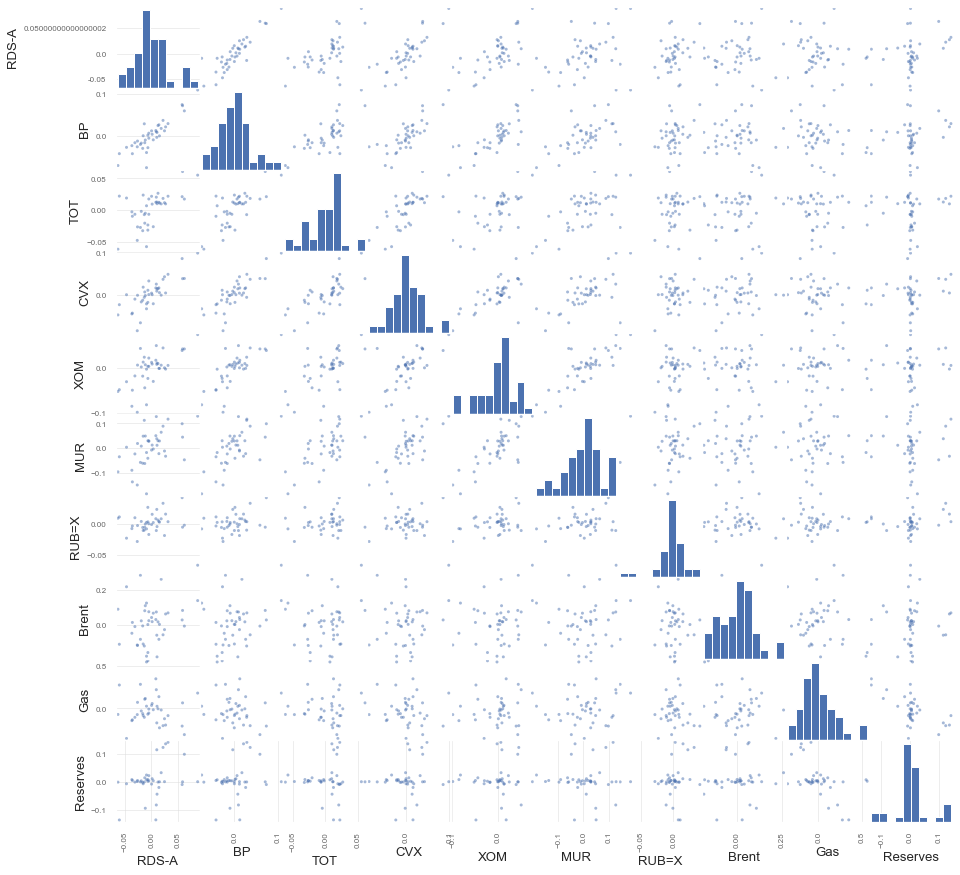

In [264]:
pd.plotting.scatter_matrix(ext_prices.pct_change(),figsize=(15,15))
plt.show()

In [265]:
# ext_prices

In [266]:
#Regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

dfs=ext_prices.pct_change().dropna(axis=0)
# dfs=dfs[dfs['Brent']<-0.1]
x=dfs.drop("RUB=X",axis=1)
y=dfs[["RUB=X"]]
# x2=x.pow(2)
# x2.columns=[i+"^2" for i in x2.columns]
# x=pd.concat([x,x2],axis=1)
# x = sm.add_constant(x, prepend=False)
x.head(3)
# y

,RDS-A,BP,TOT,CVX,XOM,MUR,Brent,Gas,Reserves
Date,,,,,,,,,
2018-02-18,-0.036857,-0.022893,-0.002619,-0.044895,-0.085263,-0.089946,-0.046701,-0.144330,0.009337
2018-02-25,0.000626,0.012115,0.021880,0.004013,0.012935,-0.008274,0.042613,0.036145,-0.006828
2018-03-11,-0.012357,-0.015960,-0.020384,0.006750,-0.043983,-0.062571,0.081146,0.108527,0.015746


In [267]:
mod = sm.OLS(y, x)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  RUB=X   R-squared (uncentered):                   0.214
Model:                            OLS   Adj. R-squared (uncentered):             -0.014
Method:                 Least Squares   F-statistic:                             0.9369
Date:                Sun, 10 May 2020   Prob (F-statistic):                       0.508
Time:                        04:42:41   Log-Likelihood:                          101.60
No. Observations:                  40   AIC:                                     -185.2
Df Residuals:                      31   BIC:                                     -170.0
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [739]:
prices=prices[ASSETS]
future_cov = risk_models.sample_cov(prices_with_reserves)
future_cov

,Reserves,RDS-A,BP,TOT,CVX,XOM,MUR,BNO,RUB=X
Reserves,0.028478,-0.033848,-0.038904,-0.049320,-0.013503,-0.003983,0.001404,0.006079,0.000539
RDS-A,-0.033848,2.229441,2.378883,1.750450,1.443911,1.275534,1.806242,1.998652,0.481256
BP,-0.038904,2.378883,2.790734,2.004166,1.716357,1.731194,2.555072,2.464592,0.637354
TOT,-0.049320,1.750450,2.004166,1.710128,1.259173,1.167205,1.774214,1.989510,0.557689
CVX,-0.013503,1.443911,1.716357,1.259173,1.358628,1.288969,1.945262,1.754456,0.442047
XOM,-0.003983,1.275534,1.731194,1.167205,1.288969,1.754152,2.552315,1.835380,0.520532
MUR,0.001404,1.806242,2.555072,1.774214,1.945262,2.552315,4.761990,2.982141,0.736773
BNO,0.006079,1.998652,2.464592,1.989510,1.754456,1.835380,2.982141,3.958504,0.561048
RUB=X,0.000539,0.481256,0.637354,0.557689,0.442047,0.520532,0.736773,0.561048,0.511866


In [740]:
portfolio_optimizer=OptPortfolio(target_function="max_sharpe",
                                 budget=100000)
cv=FinancialCrossValidation(n_splits=5)
cv.validate(prices,portfolio_optimizer)

(107, 7)
1
Period end: 2017-02-01 00:00:00
Leftover: $448.61
Alloc: ${'RDS-A': 26.0, 'BP': 1.0, 'TOT': 9.0, 'RUB=X': 4.0}
Period end: 2017-08-01 00:00:00
Leftover: $346.93
Alloc: ${'RDS-A': 21.0, 'TOT': 9.0}
(107, 7)
1
Period end: 2017-02-01 00:00:00
Leftover: $1515.92
Alloc: ${'RDS-A': 9.0, 'BP': 10.0, 'TOT': 5.0, 'CVX': 2.0, 'RUB=X': 3.0, 'MUR': 10.0}
Period end: 2018-01-24 00:00:00
Leftover: $1585.97
Alloc: ${'RDS-A': 8.0, 'BP': 8.0, 'TOT': 4.0, 'CVX': 2.0, 'RUB=X': 6.0, 'MUR': 10.0}
(107, 7)

c:\python_venvs\finance\lib\site-packages\pypfopt\efficient_frontier.py:183: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."



1
Period end: 2017-02-01 00:00:00
Leftover: $75.55
Alloc: ${'RDS-A': 6.0, 'BP': 9.0, 'TOT': 6.0, 'CVX': 2.0, 'RUB=X': 17.0, 'XOM': 1.0, 'MUR': 7.0}
Period end: 2018-07-19 00:00:00
Leftover: $472.42
Alloc: ${'RDS-A': 6.0, 'BP': 9.0, 'TOT': 6.0, 'CVX': 2.0, 'RUB=X': 17.0, 'XOM': 1.0, 'MUR': 9.0}
(107, 7)
1
Period end: 2017-02-01 00:00:00
Leftover: $43.37
Alloc: ${'RDS-A': 7.0, 'BP': 10.0, 'TOT': 6.0, 'CVX': 2.0, 'RUB=X': 75.0, 'MUR': 6.0}
Period end: 2019-01-14 00:00:00
Leftover: $54.75
Alloc: ${'RDS-A': 6.0, 'BP': 10.0, 'TOT': 6.0, 'CVX': 2.0, 'RUB=X': 99.0, 'MUR': 7.0}
(107, 7)
1
Period end: 2017-02-01 00:00:00
Leftover: $62.38
Alloc: ${'RDS-A': 8.0, 'BP': 10.0, 'TOT': 6.0, 'CVX': 2.0, 'RUB=X': 21.0, 'XOM': 1.0, 'MUR': 2.0}
Period end: 2019-07-09 00:00:00
Leftover: $51.61
Alloc: ${'RDS-A': 8.0, 'BP': 11.0, 'TOT': 6.0, 'CVX': 3.0, 'RUB=X': 21.0, 'MUR': 2.0}


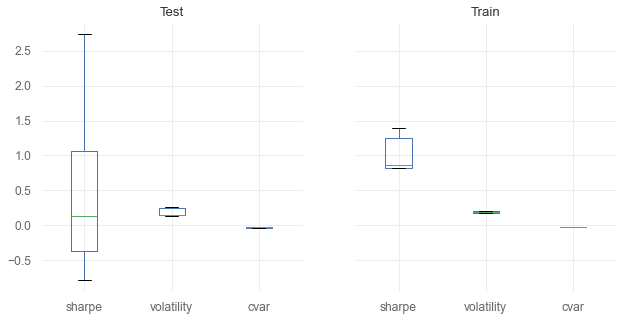

In [741]:
Visualizer.draw_comparing_boxplots(cv)

In [742]:
# prices.dropna(axis=0)

1
Period end: 2017-02-01 00:00:00
Leftover: $6.04
Alloc: ${'RDS-A': 5.0, 'BP': 7.0, 'TOT': 5.0, 'CVX': 2.0, 'RUB=X': 163.0, 'XOM': 2.0, 'MUR': 10.0}


Text(0.5, 1.0, 'Portfolio')

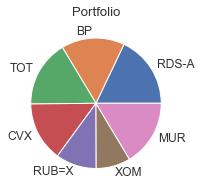

In [743]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
portfolio_optimizer=OptPortfolio(target_function="efficient_risk",
                                 target_function_params={"target_volatility":0.2},
                                 budget=100000)
# portfolio_optimizer=OptPortfolio(target_function="max_sharpe",budget=100000)
portfolio_optimizer.fit(prices.dropna(axis=0))
portfolio=portfolio_optimizer.predict(prices)
axs.pie(portfolio.iloc[-1], labels=portfolio.columns)
axs.set_title("Portfolio")

1
Period end: 2017-02-01 00:00:00
Leftover: $42.90
Alloc: ${'RDS-A': 7.0, 'BP': 9.0, 'TOT': 7.0, 'CVX': 2.0, 'RUB=X': 5.0, 'MUR': 10.0}


c:\python_venvs\finance\lib\site-packages\pypfopt\efficient_frontier.py:183: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


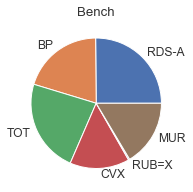

In [744]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
benchmark=OptPortfolio(target_function="max_sharpe",budget=100000)
benchmark.fit(prices.dropna(axis=0))
portfolio_benchmark=benchmark.predict(prices)
axs.pie(portfolio_benchmark.iloc[-1], labels=portfolio_benchmark.columns)
axs.set_title("Bench")
plt.show()

In [745]:
# portfolio.sum(axis=1).sharpe(prices))
port_sum=portfolio.sum(axis=1)
port_sum.sharpe(rf=0.5)

port_bench_sum=portfolio_benchmark.sum(axis=1)
port_bench_sum.sharpe(rf=0.5)
# port_sum.periods


1
1


0.5494853844548516

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2017-02-01  2017-02-01
End Period                 2019-12-31  2019-12-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          25.99%      3.02%
CAGR%                      8.26%       1.03%
Sharpe                     0.55        0.16
Sortino                    0.82        0.24
Max Drawdown               -21.87%     -12.37%
Longest DD Days            449         476
Volatility (ann.)          20.23%      11.68%
R^2                        0.13        0.13
Calmar                     0.38        0.08
Skew                       0.31        0.98
Kurtosis                   2.07        5.05

Expected Daily %           0.04%       0.0%
Expected Monthly %         0.66%       0.08%
Expected Yearly %          8.0%        1.0%
Kelly Criterion            6.76%       -0.03%
Risk of Ruin               0.0%        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-10-08,2019-08-15,2019-12-31,449,-21.866410,-21.549644
2,2018-01-16,2018-02-21,2018-04-10,84,-13.167543,-12.874391
3,2017-02-03,2017-04-20,2017-07-31,178,-10.029812,-9.260423
4,2017-08-03,2017-08-31,2017-09-20,48,-7.078798,-6.764610
5,2018-05-21,2018-05-29,2018-06-11,21,-6.210002,-4.608271


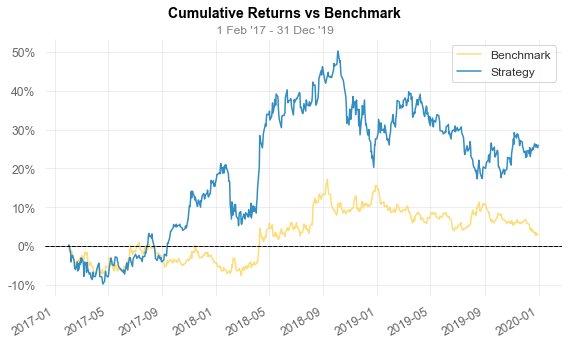

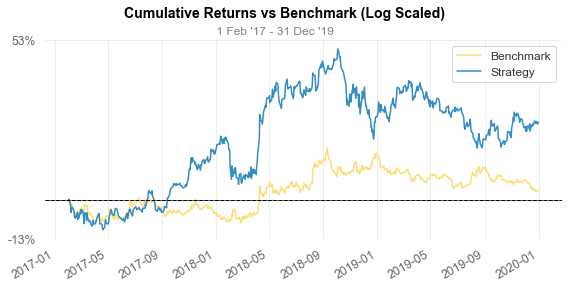

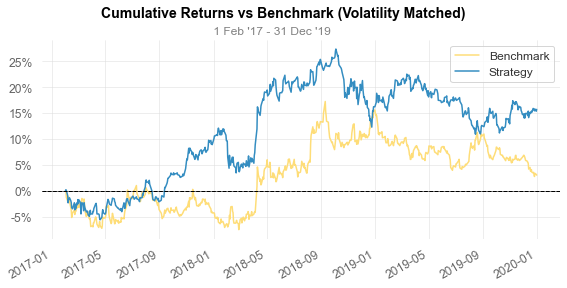

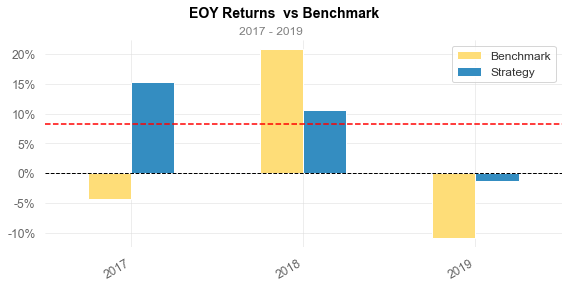

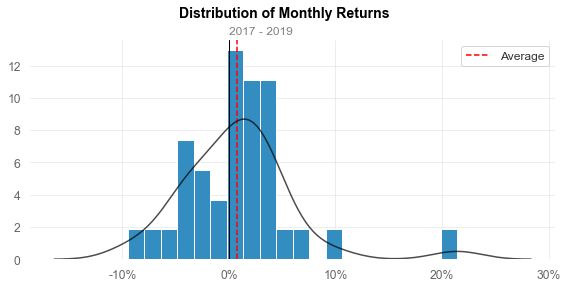

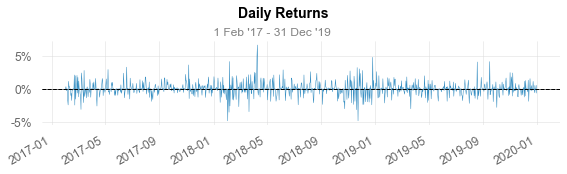

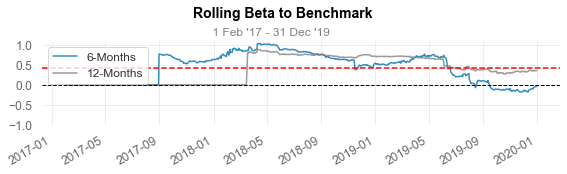

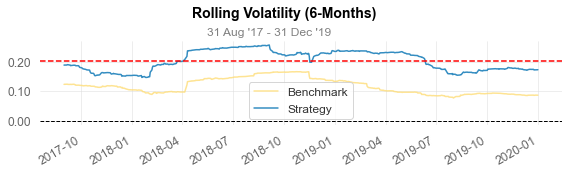

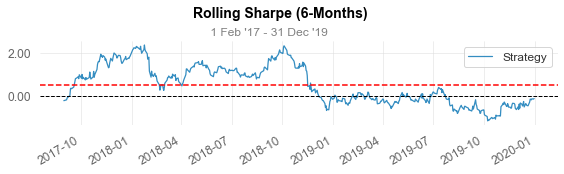

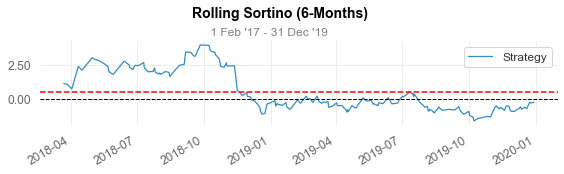

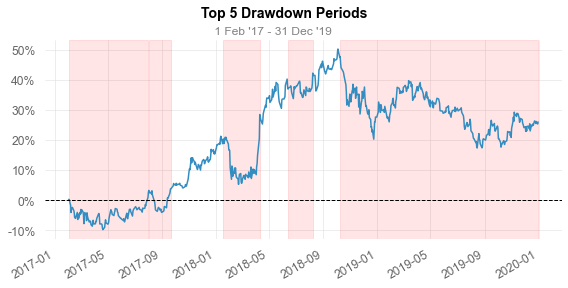

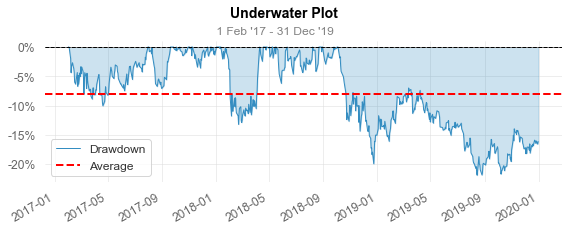

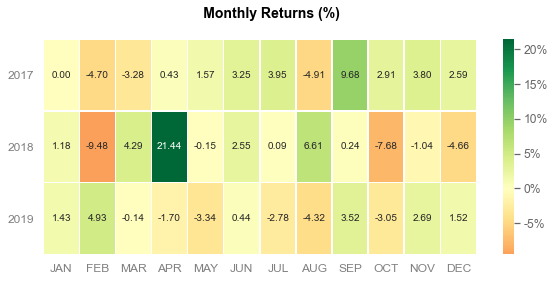

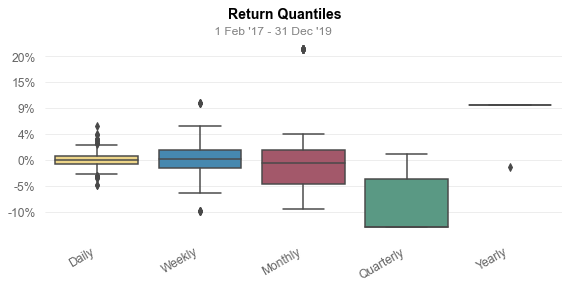

In [746]:
qs.reports.full(port_bench_sum,benchmark=prices['RUB=X'].dropna()*1000)

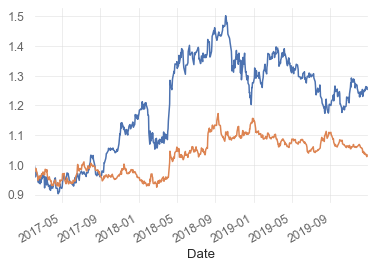

In [754]:
(port_bench_sum/port_bench_sum[0]).plot()
(prices['RUB=X']/prices['RUB=X'][0]).plot()


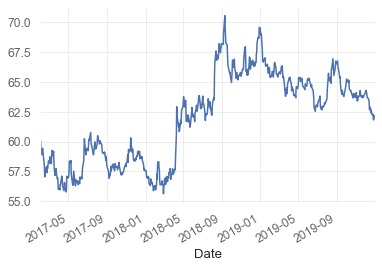

In [750]:
prices['RUB=X'].plot()